In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from IPython.display import display, Markdown
import time

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import  metrics
# from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedBaggingClassifier
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D as Conv1D
from keras.layers import ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

In [3]:
df = pd.read_csv("training_set.csv")
location_df = pd.read_csv("locations.csv")

#check all columns
df_loc = df.join(location_df.set_index('Location'), on='Location')
print(df_loc.shape)
df_loc.columns

(109641, 26)


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow', 'lat', 'lon'],
      dtype='object')

In [4]:
# take out test set (2011, 2015)
df["Date"] = pd.to_datetime(df['Date'])
df.insert(1, "Year", df["Date"].dt.year, True)
test = df[(df.Year == 2015) | (df.Year == 2011)].copy(deep = True)
train = df[(df.Year != 2015) & (df.Year != 2011)].copy(deep = True)

In [5]:
print("testset percentage:", "{0:.2%}".format(len(test)/len(df)))

testset percentage: 29.51%



number of obdervations with rainfall>200mm: 11


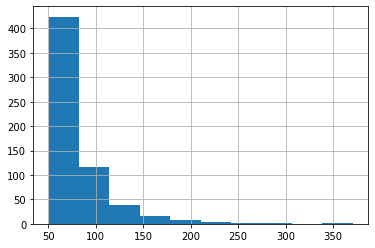

In [6]:
df.Rainfall[df.Rainfall>50].hist()
print()
print("number of obdervations with rainfall>200mm:",len(df.Rainfall[df.Rainfall>200]))

In [7]:
# USEAGE
# Each function takes 'df' as pandas dataframe object and returns the modified dataframe.
# add_locs also takes a datafrane of the locations
# example:
#   data = pd.read_csv("weatherAUS.csv")
#   data = wind_vectors(data)
#   locations = pd.read_csv("lcoations.csv")
#   data = add_locs(data, locations)

import pandas as pd
import numpy as np
import datetime

# add location coordinates
def add_locs(df, location_df):
    return df.join(location_df.set_index('Location'), on='Location')

# convert yes and no strings to binary
def binary_target(df):
    df["RainTomorrow"] = df["RainTomorrow"].replace(('Yes', 'No'), (1, 0))
    df["RainToday"] = df["RainToday"].replace(('Yes', 'No'), (1, 0))
    return df

def wind_vectors(df):
    df['WindGustDir'] = df['WindGustDir'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    df['WindDir9am'] = df['WindDir9am'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    df['WindDir3pm'] = df['WindDir3pm'].replace(
        ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
        (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5)
    )

    wv = df.pop('WindGustSpeed')
    wd = df.pop('WindGustDir')*np.pi/180
    df['WindGustX'] = wv*np.cos(wd)
    df['WindGustY'] = wv*np.sin(wd)

    wv = df.pop('WindSpeed9am')
    wd = df.pop('WindDir9am')*np.pi/180
    df['Wind9amX'] = wv*np.cos(wd)
    df['Wind9amY'] = wv*np.sin(wd)

    wv = df.pop('WindSpeed3pm')
    wd = df.pop('WindDir3pm')*np.pi/180
    df['Wind3pmX'] = wv*np.cos(wd)
    df['Wind3pmY'] = wv*np.sin(wd)

    return df

def date_to_signal(df):
    data_date = pd.to_datetime(df['Date'])
    timestamp_s = data_date.map(datetime.datetime.timestamp)
    day = 24*60*60
    year = (365.2425)*day
    month = data_date.dt.month
    season = ((month -1)%12 + 3)//3
    df['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
    df['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
    df['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
    df['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))
    df['monthsin'] = np.sin((month-1)*(2.*np.pi/12))
    df['monthcos'] = np.cos((month-1)*(2.*np.pi/12))
    df['seasonsin'] = np.sin((month-1)*(2.*np.pi/4))
    df['seasoncos'] = np.cos((month-1)*(2.*np.pi/4))

    return df

# shif certain column down by 1 day (each entry gets yesterday's info)
def lag(df):
    df = df.copy(deep= True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(["Date","Location"])
    lag_cols = ['MinTemp','MaxTemp','Rainfall','Humidity3pm','Pressure3pm','WindGustX','WindGustY','RainToday']

    shit_days = [1,2]
    for d in shit_days:
        shifted = df[lag_cols].groupby(level="Location").shift(d)
        shifted = shifted.rename(columns=lambda x: x+"_lag"+str(d))
        df = pd.merge(df, shifted, how='left', left_index=True, right_index=True)
           
    df = df.reset_index() 
    
    return df

# deiffernce from month and year average
def mean_diff(df):
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.insert(2, "Month", df["Date"].dt.month, True)
    df = df.set_index(["Location", "Year", "Month"])
    mean_cols = ['MinTemp','MaxTemp','Rainfall','Humidity3pm','Pressure3pm','WindGustX','WindGustY']
    
    # month mean
    mean = pd.DataFrame(df[mean_cols].groupby(level=[0,1,2]).mean())
    mean = mean.rename(columns=lambda x: x+"_month_mean")
    df = pd.merge(df, mean, how='left', left_index=True, right_index=True)
    
    # year mean
    mean_year = pd.DataFrame(df[mean_cols].groupby(level=[0,1]).mean())
    mean_year = mean_year.rename(columns=lambda x: x+"_year_mean")
    df = pd.merge(df, mean_year, how='left', left_index=True, right_index=True)
    
    for col in mean_cols:
        #month diff
        mean = col+"_month_mean"
        new_name = col + "_month_diff"
        df[new_name] = df[col] - df[mean]
        df.drop(mean,axis=1,inplace=True)
        
        #year diff
        mean_year = col+"_year_mean"
        new_name_year = col + "_year_diff"
        df[new_name_year] = df[col] - df[mean_year]
        df.drop(mean_year,axis=1,inplace=True)
    
    df = df.reset_index() 
    df.drop("Month",axis=1,inplace=True)
    
    return df

def aug_all(df, location_df):
    df = add_locs(df, location_df)
    df = binary_target(df)
    df = date_to_signal(df)
    df = wind_vectors(df)
    df = lag(df)
    df = mean_diff(df)
    
    return df

In [8]:
# USEAGE
# df should have turned 'Date' column as pd.to_datetime(df['Date'])
# df has inserted a 2nd colum 'Year': df.insert(1, "Year", df["Date"].dt.year, True)
# median = None: this is to preprocess test data that's never seen
# median != None, will return processed df, and medians, powertransform fit, and minmaxsclar fit from training data, 
# They will be used to transform test data.

def preprocess(df, median = None, pt_fit = None, mms_f = None):

    
    ### 1. add lon, lat columns and features engineering
    df = aug_all(df, location_df)
    #df = df.sort_index()
    
    ### 2. drop some column ###
    df.drop("Date",axis=1,inplace=True)
#     df.drop("Year",axis=1,inplace=True)
    df.drop("RISK_MM",axis=1,inplace = True)
    #remove highly correlated columns
#     df.drop(columns = ["Temp3pm", "Temp9am", "Pressure9am"], axis=1, inplace = True)
    #print('1. columns:', df.columns)
    
    ### 3. define columns ###
    # high missing % columns
    miss_col_30 = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
    
    # 
    
    # catogorical and numerical columns
    cat_cols = []
    num_cols = []
    other_cols = []

    for each in df.columns:
        if df[each].dtype == "object":
            cat_cols.append(each)
        elif df[each].dtype == "float64":
            num_cols.append(each)
        else:
            other_cols.append(each)

    
    ### 4. data preprocessing ###
    
    # drop columns with too many missing values
    df_clean = df.copy(deep = True)
#     df_clean.drop(columns = miss_col_30, axis=1, inplace = True)
#     to_remove = miss_col_30
#     num_cols = [i for i in num_cols if i not in to_remove]
    
    # Fill missing value with median
    # if this is for training data
    if median == None:
        medians = []
        for k in num_cols:
            df_clean[k].fillna(value=df[k].median(),inplace=True)
            medians.append(df[k].median())
    # # if this is for test data, use the median values of training data
    else: 
        medians = median
        i = 0
        for k in num_cols:
            df_clean[k].fillna(value = medians[i],inplace=True)
            i += 1
        
    # one hot encoder
    df1 = pd.get_dummies(df_clean.Location)
    df_prepared = pd.concat([df_clean, df1], axis=1)
    
    # drop more columns 
    df_prepared.drop(columns = ["Location"],axis=1,inplace=True)
    #print('1. columns:',df_prepared.columns)
    
    # Drop rainfall outliers: only 13 entries, but they stretch the range to almost twice.
    df_prepared = df_prepared.drop(df_prepared[df_prepared['Rainfall']> 200].index)

    
#     if pt_fit == None:
#         # Power transform 'Rainfall' column that's serious skewed
#         a = np.array(df_prepared['Rainfall'].values.tolist()).reshape(-1, 1)
#         pt = PowerTransformer(method='yeo-johnson')
#         pt_fit = pt.fit(a)
#         features_trans = pt_fit.transform(a)
#         # df1.skew()
#         df_prepared['Rainfall'] = features_trans
#     else: 
#         a = np.array(df_prepared['Rainfall'].values.tolist()).reshape(-1, 1)
#         features_trans = pt_fit.transform(a)
#         # df1.skew()
#         df_prepared['Rainfall'] = features_trans
    
    
    #Normalize
    if mms_f == None:
        mms = MinMaxScaler()
        mms_fit = mms.fit(df_prepared)
        df_prepared[df_prepared.columns[:]] = mms_fit.fit_transform(df_prepared)
    else: 
        mms_fit = mms_f
        df_prepared[df_prepared.columns[:]] = mms_fit.fit_transform(df_prepared)
    
    
    if median == None:
        return df_prepared, medians, pt_fit, mms_fit
    else:
        return df_prepared
    

In [9]:
# transform traning data
train_df = train.copy(deep=True)
train_df, medians, pt_fit, mms_fit = preprocess(train_df)

train.shape, train_df.shape

((77284, 25), (77278, 111))

In [10]:
# tranform test data
test_df = test.copy(deep=True)
# use the medians in training set to fill missing values in test days
test_df= preprocess(test, medians, pt_fit, mms_fit)
test.shape, test_df.shape

((32357, 25), (32352, 111))

# 3. Prepare for training
## 3.1 train, test, validation split

In [11]:
X_train = train_df.drop(columns = ["RainTomorrow",'Year'], axis = 1)
y_train = train_df["RainTomorrow"]

X_test = test_df.drop(columns = ["RainTomorrow",'Year'], axis = 1)
y_test = test_df["RainTomorrow"]

# list of columns
l = X_train.columns
print("X train:",X_train.shape, "\ny train:", y_train.shape, "\nX test:",X_test.shape, "\ny test:",y_test.shape)

X train: (77278, 109) 
y train: (77278,) 
X test: (32352, 109) 
y test: (32352,)


In [12]:
#cross validation set
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #stratify = y_train
print("X train1:",X_train1.shape, "\ny train1:", y_train1.shape, "\nX valid:",X_valid.shape, "\ny valid:",y_valid.shape)

X train1: (61822, 109) 
y train1: (61822,) 
X valid: (15456, 109) 
y valid: (15456,)


### 3.1.1 Some functions

In [13]:
def train_model(clf, X_train = X_train):
    clf = clf.fit(X_train, y_train)
    y_pred=clf.predict(X_train)
    print('Full training set training accuracy:',"{0:.2%}".format(accuracy_score(y_train,y_pred)))
    return clf

# keep track of the model trained with 15 most importat features
model_15f = {}

In [14]:
# visualize confusion matrix
def visual_cm(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred,labels = [1,0])
    group_names = ['TP','FN','FP','TN']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = [1,0], yticklabels = ['Rain','No Rain'])
    TP = cm[0,0]
    FN = cm[0,1]
    FP = cm[1,0]
    TN = cm[1,1]
    sensitivity = round(cm[0,0]/(cm[0,0]+cm[0,1]),2)
    specificity = round(cm[1,1]/(cm[1,0]+cm[1,1]),2)
    precision = round(TP/(TP+FP),2)
    f1_score = round((2*(sensitivity * precision) / (sensitivity + precision)),2)
    
    print("3. Precision(How many days labeled as rainy are actually rainy?):",precision)
    print("4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?):", sensitivity)
    print("5. Specificity(Of all the normal days, how many of those did we correctly predict?):", specificity)
    print("6. F1 score:",f1_score)
    

In [15]:
# Cross validation and confusion matrix
def cross_validation(clf, X_train = X_train1, y_train = y_train1, X_valid=X_valid, y_valid=y_valid):
    time0= time.time()
    clf = clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred_train)
    print("1. Training set accuracy:","{0:.2%}".format(acc))
    
    y_pred = clf.predict(X_valid)
    score_cv = accuracy_score(y_valid, y_pred)
    print("2. Validation accuracy:", "{0:.2%}".format(score_cv))
    
    if acc - score_cv < -0.01 :
        print("       Underfitting by:", "{0:.2%}".format(score_cv - acc))
#     print("3. Classification_report:\n",classification_report(y_valid, y_pred))
    
    
    
#     print("5. Confusion matric of validation set:")
    visual_cm(y_valid, y_pred)
    print("7. ROC Area under Curve:", round(metrics.roc_auc_score(y_valid, y_pred),2))
    plt.show()
    print("Time spent:", round((time.time()-time0),2))
    

In [16]:
# use 15 most Important features based on coefficient
def cv_important_features(clf, clf_coef= None, X_train = X_train, y_train = y_train):
    
    clf = clf.fit(X_train, y_train)
    
    # if random forest
    if clf_coef:
        coef = np.round(clf.feature_importances_,2)
        coef = list(coef.reshape(coef.shape[0],))
    else: 
        coef = np.round(clf.coef_,2)
        coef = list(coef.reshape(coef.shape[1],))
    l = X_train.columns

    d = {} 
    for key in l: 
        for value in coef: 
            d[key] = value 
            coef.remove(value) 
            break

    predictor_coef = {k: v for k, v in sorted(d.items(), reverse=True, key=lambda item: abs(item[1]))}
    # select top 1o features 
    impt_15f= [k for k,v in predictor_coef.items()][:15]
    impt_10f = impt_15f[:10]
    
    # compared wiht cv using top 15 features
    start_time_sgd_impt = time.time()
    scores_impt = cross_val_score(clf, X_train[impt_15f], y_train, cv=5, scoring="accuracy")
    print("Took  %s seconds  for 5-fold CV using 15 most important features" % round((time.time() - start_time_sgd_impt),2))
    print("cv scores using 15 most important features:",scores_impt,)
    avg_scores = scores_impt.mean()
    print('Average score:', "{0:.2%}".format(avg_scores))
    print()
    
    # compared wiht cv using all features
    start_time = time.time()
    scores_all = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Took %s seconds for 5-fold CV using all feature" % round((time.time() - start_time),2))
    print("cv scores using all features:",scores_all)
    avg_scores_all = scores_all.mean()
    print('Average score:', "{0:.2%}".format(avg_scores_all))
    print()
    
    diff = round((avg_scores - avg_scores_all)*100,2)

    if (diff>=0):
        print('Using most important 15 features IMPROVED average CV accuracy by '+str(diff)+'%')
    else:
        print('Using most important 15 features decresed average CV accuracy by '+str(diff)+'%')
    
    return predictor_coef, impt_15f, scores_impt, scores_all

# 4. Train Models

## 4.1 SGD classifier - FAST!

#Stochastic Gradient Descent (SGD) classifier. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

1. Training set accuracy: 84.74%
2. Validation accuracy: 84.67%
3. Precision(How many days labeled as rainy are actually rainy?): 0.71
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.51
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.94
6. F1 score: 0.59
7. ROC Area under Curve: 0.72


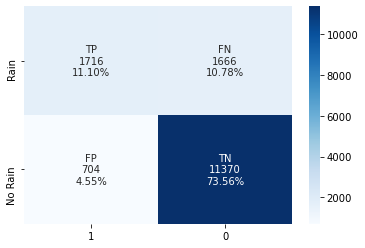

Time spent: 0.9


In [17]:
sgd_clf = SGDClassifier(random_state=42)
cross_validation(sgd_clf)

###  4.1.1 5 fold Cross validation and most important predictors

In [18]:
predictor_coef_sgd, impt_15f_sgd, scores_impt_sgd, scores_all_sgd = cv_important_features(sgd_clf)

Took  0.88 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.83909161 0.83812112 0.83106884 0.84419282 0.83882239]
Average score: 83.83%

Took 3.42 seconds for 5-fold CV using all feature
cv scores using all features: [0.83799172 0.77620342 0.77659161 0.84296344 0.84082821]
Average score: 81.49%

Using most important 15 features IMPROVED average CV accuracy by 2.33%


1. Training set accuracy: 83.93%
2. Validation accuracy: 83.95%
3. Precision(How many days labeled as rainy are actually rainy?): 0.76
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.39
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.97
6. F1 score: 0.52
7. ROC Area under Curve: 0.68


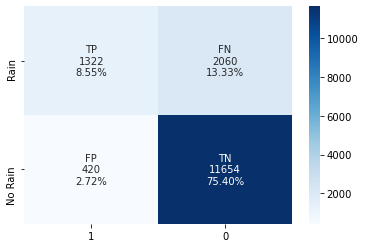

Time spent: 0.32


In [19]:
cross_validation(sgd_clf, X_train = X_train1[impt_15f_sgd], X_valid = X_valid[impt_15f_sgd])

In [20]:
# use most important 15 features
impt_15f_sgd

['Humidity3pm',
 'Rainfall',
 'Rainfall_year_diff',
 'Pressure3pm',
 'Pressure3pm_lag1',
 'Rainfall_month_diff',
 'Pressure3pm_year_diff',
 'MinTemp',
 'Pressure3pm_month_diff',
 'WindGustY_month_diff',
 'Humidity3pm_year_diff',
 'MinTemp_month_diff',
 'Humidity3pm_lag1',
 'WindGustY_year_diff',
 'WindGustY']

In [21]:
model_15f[sgd_clf] = impt_15f_sgd

### 4.1.2 Use PCA

In [22]:
from sklearn.decomposition import PCA

pca = PCA(20, whiten=True)
pac_train = pca.fit(X_train)
principalComponents = pac_train.transform(X_train)
#fit-train, transform-test
X_train_pca = pd.DataFrame(data = principalComponents)
X_train_pca.shape

# PCA cross validation set
X_train1_pca, X_valid_pca, y_train1_pca, y_valid_pca = train_test_split(X_train_pca , y_train, test_size=0.20, stratify = y_train, random_state=0)
print("X train1 pca:",X_train1_pca.shape, "\ny train1:", y_train1_pca.shape, "\nX valid pca:",X_valid_pca.shape, "\ny valid:",y_valid.shape)

X train1 pca: (61822, 20) 
y train1: (61822,) 
X valid pca: (15456, 20) 
y valid: (15456,)


1. Training set accuracy: 83.17%
2. Validation accuracy: 82.75%
3. Precision(How many days labeled as rainy are actually rainy?): 0.65
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.45
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.93
6. F1 score: 0.53
7. ROC Area under Curve: 0.69


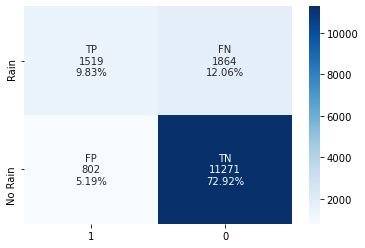

Time spent: 0.45


In [23]:
# use PCA for cross validation
sgd_clf_pca = SGDClassifier(random_state=42)
cross_validation(sgd_clf_pca, X_train = X_train1_pca, y_train = y_train1_pca, X_valid = X_valid_pca, y_valid = y_valid_pca )

sensitivity dropped

### 4.1.3* cross validate on a whole year

In [24]:
# 2015 is held out as the test set, other years will be held out one by one as validation set.
train_df1 = train_df.copy(deep=True)

def cross_validation_year():
    cv_score_year = []
    for y in train_df1.Year.unique():

        train1 = train_df1 [(train_df1.Year != y)]
        valid = train_df1 [train_df1.Year == y]

        X_train1 = train1.drop(columns = ["RainTomorrow", "Year"], axis = 1)
        y_train1 = train1["RainTomorrow"]

        X_valid = valid.drop(columns = ["RainTomorrow", "Year"], axis=1)
        y_valid = valid["RainTomorrow"]

        sgd_clf1 = SGDClassifier(random_state=42)
        sgd_clf1.fit(X_train1, y_train1)
        y_pred_sgd1=sgd_clf1.predict(X_valid)
        score = "{0:.2%}".format(accuracy_score(y_valid,y_pred_sgd1))
        cv_score_year.append(score)
        
    return cv_score_year

cross_validation_year()

['83.21%', '84.76%', '83.62%', '84.47%', '84.93%', '84.63%', '78.69%']

#### going to expect diffent test result####

## 4.2 Logistic Regression

1. Training set accuracy: 84.88%
2. Validation accuracy: 85.09%
3. Precision(How many days labeled as rainy are actually rainy?): 0.73
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.5
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.59
7. ROC Area under Curve: 0.73


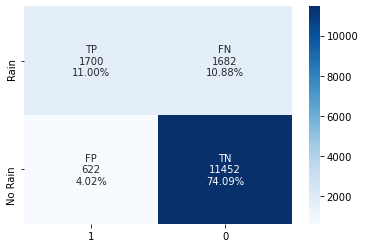

Time spent: 34.22


In [91]:
clf_lr = LogisticRegression(C=100, penalty='l1', solver='liblinear')
cross_validation(clf_lr)

1. Training set accuracy: 84.84%
2. Validation accuracy: 85.18%
3. Precision(How many days labeled as rainy are actually rainy?): 0.74
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.5
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.6
7. ROC Area under Curve: 0.73


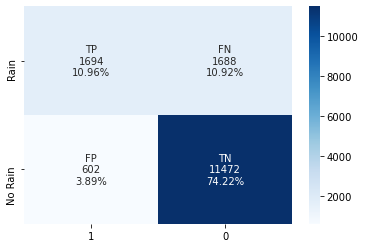

Time spent: 29.09


In [93]:
clf_lr = LogisticRegression(C=0.9, penalty='l1', solver='liblinear')
cross_validation(clf_lr)

1. Training set accuracy: 83.62%
2. Validation accuracy: 83.27%
3. Precision(How many days labeled as rainy are actually rainy?): 0.69
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.43
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.53
7. ROC Area under Curve: 0.69


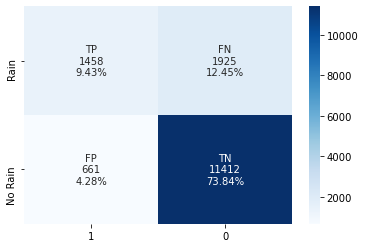

Time spent: 0.39


In [97]:
cross_validation(clf_lr, X_train = X_train1_pca, y_train = y_train1_pca, X_valid = X_valid_pca, y_valid = y_valid_pca )

A bit under fitting

In [26]:
# see the features removed by lasso
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(X_train, y_train)
lasso_removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
lasso_removed_feats

Index(['Humidity9am', 'Temp9am', 'Rainfall_lag1', 'Rainfall_lag2',
       'WindGustX_year_diff', 'Launceston', 'PerthAirport', 'SydneyAirport'],
      dtype='object')

In [27]:
predictor_coef_lr, impt_15f_lr, scores_impt_lr, scores_all_lr = cv_important_features(clf_lr)

Took  35.58 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.8448499  0.83592133 0.83216874 0.84665157 0.84102232]
Average score: 84.01%

Took 197.22 seconds for 5-fold CV using all feature
cv scores using all features: [0.85209627 0.76358696 0.75808747 0.83274021 0.83778712]
Average score: 80.89%

Using most important 15 features IMPROVED average CV accuracy by 3.13%


1. Training set accuracy: 84.66%
2. Validation accuracy: 84.83%
3. Precision(How many days labeled as rainy are actually rainy?): 0.72
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.5
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.59
7. ROC Area under Curve: 0.72


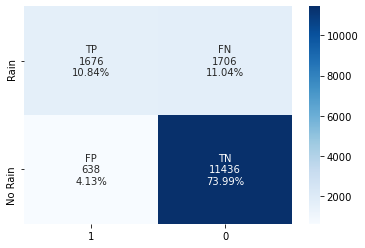

Time spent: 10.76


In [90]:
cross_validation(clf_lr, X_train = X_train1[imp_15_Freq], X_valid = X_valid[imp_15_Freq])

## SVC

1. Training set accuracy: 84.93%
2. Validation accuracy: 85.08%
3. Precision(How many days labeled as rainy are actually rainy?): 0.76
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.47
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.96
6. F1 score: 0.58
7. ROC Area under Curve: 0.71


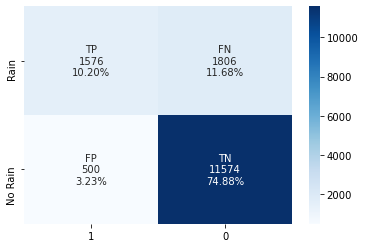

Time spent: 587.43


In [80]:
clf_svc = svm.SVC(kernel='linear', C=1)
cross_validation(clf_svc)

1. Training set accuracy: 83.57%
2. Validation accuracy: 83.17%
3. Precision(How many days labeled as rainy are actually rainy?): 0.71
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.39
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.5
7. ROC Area under Curve: 0.67


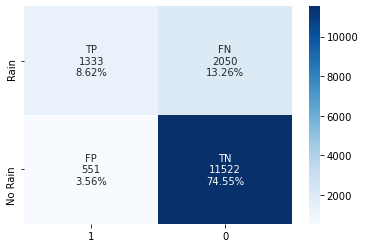

Time spent: 233.39


In [85]:
# use PCA for cross validation
cross_validation(clf_svc, X_train = X_train1_pca, y_train = y_train1_pca, X_valid = X_valid_pca, y_valid = y_valid_pca )

1. Training set accuracy: 84.49%
2. Validation accuracy: 84.52%
3. Precision(How many days labeled as rainy are actually rainy?): 0.75
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.44
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.96
6. F1 score: 0.55
7. ROC Area under Curve: 0.7


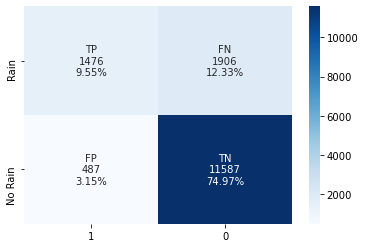

Time spent: 0.45


In [86]:
# use PCA for cross validation
cross_validation(sgd_clf, X_train = X_train1[imp_15_Freq], X_valid = X_valid[imp_15_Freq])

## 4.4 KNN

1. Training set accuracy: 86.23%
2. Validation accuracy: 80.91%
3. Precision(How many days labeled as rainy are actually rainy?): 0.61
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.36
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.93
6. F1 score: 0.45
7. ROC Area under Curve: 0.65


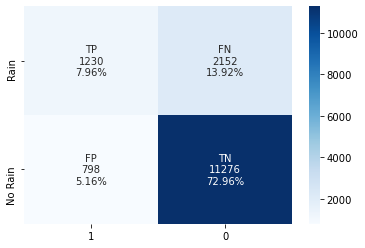

Time spent: 149.57


In [84]:
knn = KNeighborsClassifier(n_neighbors=5)
cross_validation(knn)
# cross_validation(knn, X_train = X_train1_pca, y_train = y_train1_pca, X_valid = X_valid_pca, y_valid = y_valid_pca )

#### K=5 overfit

## 4.5 Random Forest

1. Training set accuracy: 86.11%
2. Validation accuracy: 84.96%
3. Precision(How many days labeled as rainy are actually rainy?): 0.79
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.42
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.97
6. F1 score: 0.55
7. ROC Area under Curve: 0.7


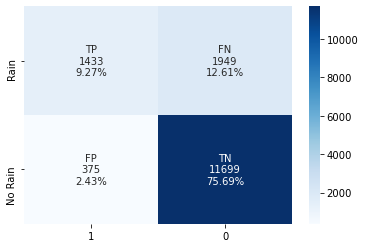

Time spent: 22.75


In [31]:
rfc=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')
cross_validation(rfc)

In [32]:
predictor_coef_rfc, impt_15f_rfc, scores_impt_rfc, scores_all_r10c = cv_important_features(rfc, 1)

Took  55.42 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.85157867 0.8449146  0.83993271 0.85092203 0.84613394]
Average score: 84.67%

Took 102.56 seconds for 5-fold CV using all feature
cv scores using all features: [0.85119048 0.8432324  0.84148551 0.8487221  0.84678098]
Average score: 84.63%

Using most important 15 features IMPROVED average CV accuracy by 0.04%


In [ ]:
# plot_roc_curve(rfc, X_train[impt_15f_rfc], y_train)
# plot_roc_curve(sgd_clf, X_train[impt_15f_sgd], y_train)
# plot_roc_curve(clf_lr, X_train[impt_15f_lr], y_train)
# plot_roc_curve(knn, X_train[impt_15f_rfc], y_train)
# plt.show()

## 4.6 Multilayer Perceptron

1. Training set accuracy: 87.53%
2. Validation accuracy: 86.25%
3. Precision(How many days labeled as rainy are actually rainy?): 0.74
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.57
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.94
6. F1 score: 0.64
7. ROC Area under Curve: 0.76


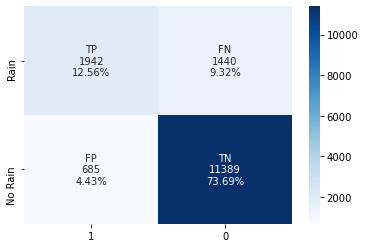

Time spent: 174.14


In [33]:
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (25,25,25),
             'activation': 'relu',
             'solver': 'lbfgs',
             'max_iter': 10000,
             'tol': 0.001,
             'batch_size' : 10,
             'early_stopping': True}

model_mlpc = MLPClassifier(**params_nn)

cross_validation(model_mlpc)

# Deal with Imbalance

## 4.6 Balanced Random Forest

1. Training set accuracy: 82.46%
2. Validation accuracy: 80.87%
3. Precision(How many days labeled as rainy are actually rainy?): 0.55
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.74
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.83
6. F1 score: 0.63
7. ROC Area under Curve: 0.78


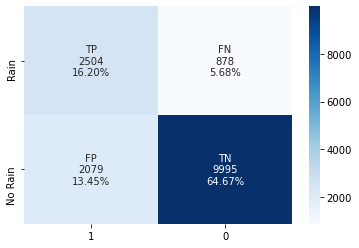

Time spent: 24.58


In [34]:
rfc_bal = RandomForestClassifier(class_weight='balanced',random_state=42, max_features='auto', 
                                 n_estimators= 200, max_depth=8, criterion='gini')
cross_validation(rfc_bal)

In [35]:
predictor_coef_brfc, impt_15f_brfc, scores_impt_brfc, scores_all_brfc = cv_important_features(rfc_bal, 1)

Took  52.13 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.81437629 0.78500259 0.78681418 0.81617599 0.80724685]
Average score: 80.19%

Took 102.98 seconds for 5-fold CV using all feature
cv scores using all features: [0.82434006 0.78616718 0.79380176 0.82296991 0.81287609]
Average score: 80.80%

Using most important 15 features decresed average CV accuracy by -0.61%


## 4.7 Balanced Bagging Classifier

1. Training set accuracy: 100.00%
2. Validation accuracy: 86.74%
3. Precision(How many days labeled as rainy are actually rainy?): 0.78
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.54
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.96
6. F1 score: 0.64
7. ROC Area under Curve: 0.75


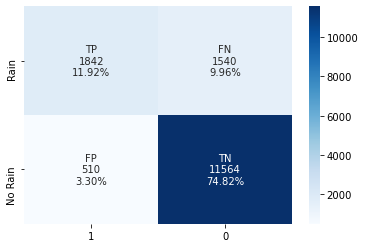

Time spent: 712.11


In [36]:
clf_bb = BalancedBaggingClassifier(random_state=42, max_features= 0.8, 
                                 n_estimators= 200, sampling_strategy = 'not majority')
cross_validation(clf_bb)

## 4.8 EasyEnsemble
Bag of balanced boosted learners.

The classifier is an ensemble of AdaBoost learners trained on different balanced boostrap samples. 
The balancing is achieved by random under-sampling.

1. Training set accuracy: 80.10%
2. Validation accuracy: 79.23%
3. Precision(How many days labeled as rainy are actually rainy?): 0.52
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.77
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.8
6. F1 score: 0.62
7. ROC Area under Curve: 0.78


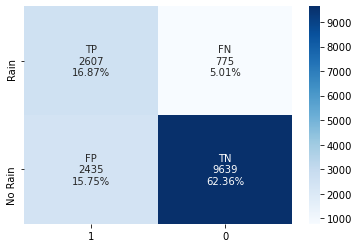

Time spent: 69.28


In [37]:
from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(random_state=42)
cross_validation(eec)

## 4.9 RUSBoostClassifier

1. Training set accuracy: 79.78%
2. Validation accuracy: 79.30%
3. Precision(How many days labeled as rainy are actually rainy?): 0.52
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.76
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.8
6. F1 score: 0.62
7. ROC Area under Curve: 0.78


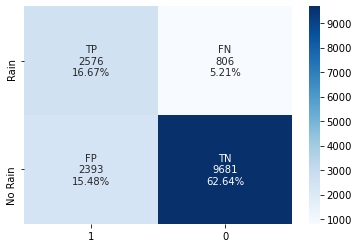

Time spent: 11.53


In [38]:
from imblearn.ensemble import RUSBoostClassifier

clf_rus = RUSBoostClassifier(random_state=0)
cross_validation(clf_rus)

# 5. Show best features

## 5.1 based on coeffients

## 5.2  use RFE.

In [51]:
from sklearn.feature_selection import RFE

# n_features_to_select=1 to rank all features
selector = RFE(sgd_clf, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)

rank1 = selector.ranking_

d1 = {} 
for key in l: 
    for value in rank1: 
        d1[key] = value 
        np.delete(rank1, np.argwhere(rank1 == 6))
        break

predictor_rank = {k: v for k, v in sorted(d1.items(), reverse=True, key=lambda item: abs(item[1]))}
# select top 10 features 
impt_15_rfe= [k for k,v in predictor_rank.items()][:15]

### 5.3 Kbest

In [52]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

selector = SelectKBest(chi2, k=15)
selector.fit_transform(X_train, y_train)
impt_15_Kbest = X_train.columns[selector.get_support(indices=True)]
impt_15_Kbest

Index(['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am',
       'Cloud3pm', 'RainToday', 'Humidity3pm_lag1', 'RainToday_lag1',
       'Humidity3pm_lag2', 'RainToday_lag2', 'Humidity3pm_month_diff',
       'Humidity3pm_year_diff', 'AliceSprings', 'Woomera'],
      dtype='object')

In [53]:
f_top15 = pd.DataFrame(
    {
     'LReg': impt_15f_lr, 
     #'SVC': impt_15f_svc,
     'RamF': impt_15f_rfc,
     'SGD':impt_15f_sgd,
     #'Balanc_RF': impt_15f_brfc,
     'RFE_sgd':impt_15_rfe,
     'Kbest':  impt_15_Kbest,
     'gradient_baggin':impt_15f_gbc
    })
f_top15

,LReg,RamF,SGD,RFE_sgd,Kbest,gradient_baggin
0,Rainfall_month_diff,Humidity3pm,Humidity3pm,MinTemp,Rainfall,Humidity3pm
1,Rainfall,Humidity3pm_year_diff,Rainfall,MaxTemp,Sunshine,Rainfall
2,Rainfall_year_diff,Humidity3pm_month_diff,Rainfall_year_diff,Rainfall,Humidity9am,Humidity3pm_year_diff
3,MinTemp,Rainfall,Pressure3pm,Evaporation,Humidity3pm,Sunshine
4,Pressure3pm,Sunshine,Pressure3pm_lag1,Sunshine,Cloud9am,Pressure3pm_month_diff
5,Pressure3pm_month_diff,Cloud3pm,Rainfall_month_diff,Humidity9am,Cloud3pm,Pressure3pm
6,Humidity3pm,RainToday,Pressure3pm_year_diff,Humidity3pm,RainToday,lon
7,MinTemp_month_diff,Rainfall_year_diff,MinTemp,Pressure9am,Humidity3pm_lag1,Pressure3pm_year_diff
8,Pressure3pm_lag1,Pressure3pm_month_diff,Pressure3pm_month_diff,Pressure3pm,RainToday_lag1,Cloud3pm
9,MaxTemp_month_diff,Humidity9am,WindGustY_month_diff,Cloud9am,Humidity3pm_lag2,WindGustY


## 5.3 Most important features

In [54]:
def longestCommonFeatures(lists):
    
    l1 = set(lists[0])
    ppl = {}
    
    for i in l1:
        if i not in ppl:
            ppl[i] = 1
        else:
            ppl[i] += 1            
            
    for l in lists[1:]:
        common = set(l).intersection(l1)
        
        for i in l:
            if i not in ppl:
                ppl[i] = 1
            else:
                ppl[i] += 1               
                
        l1 = common
      
    ppl = {k: v for k, v in sorted(ppl.items(), reverse=True, key=lambda item: abs(item[1]))}
    
    # choose the col with more than one vote
    imp_15_Freq = []
    for k,v in ppl.items():
        if v>1:
            imp_15_Freq.append(k)
            
    return common, ppl, imp_15_Freq

impt_lists = [impt_15f_lr, impt_15f_rfc, impt_15f_sgd, impt_15f_brfc,impt_15_rfe, impt_15_Kbest, impt_15f_gbc]
common, ppl, imp_15_Freq = longestCommonFeatures(impt_lists)
print("common features in all methods:",common, "\nfrequencies:")
ppl

common features in all methods: {'Humidity3pm', 'Rainfall'} 
frequencies:


{'Humidity3pm': 7,
 'Rainfall': 7,
 'Pressure3pm': 6,
 'Rainfall_month_diff': 5,
 'Pressure3pm_month_diff': 5,
 'MinTemp': 5,
 'Humidity3pm_year_diff': 5,
 'Sunshine': 5,
 'Cloud3pm': 5,
 'RainToday': 5,
 'Rainfall_year_diff': 4,
 'Pressure9am': 4,
 'Humidity3pm_month_diff': 4,
 'Humidity9am': 4,
 'Pressure3pm_year_diff': 4,
 'Cloud9am': 3,
 'Pressure3pm_lag1': 2,
 'WindGustY_year_diff': 2,
 'WindGustY_month_diff': 2,
 'MinTemp_month_diff': 2,
 'MaxTemp': 2,
 'Humidity3pm_lag1': 2,
 'WindGustY': 2,
 'MaxTemp_month_diff': 1,
 'Evaporation': 1,
 'Temp9am': 1,
 'Temp3pm': 1,
 'lat': 1,
 'RainToday_lag1': 1,
 'Humidity3pm_lag2': 1,
 'RainToday_lag2': 1,
 'AliceSprings': 1,
 'Woomera': 1,
 'lon': 1,
 'WindGustX': 1,
 'Wind3pmX': 1}

In [56]:
len(ppl), len(imp_15_Freq)

(36, 23)

### select K beast features 

#### use important features saves time and doesn't lower accuracy

# 6 Boosting

## 6.1 Gradient Boosting

1. Training set accuracy: 86.26%
2. Validation accuracy: 85.86%
3. Precision(How many days labeled as rainy are actually rainy?): 0.76
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.52
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.62
7. ROC Area under Curve: 0.74


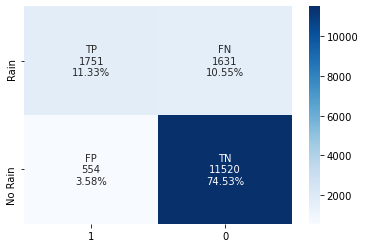

Time spent: 56.02
Took  62.09 seconds  for 5-fold CV using 15 most important features
cv scores using 15 most important features: [0.85539596 0.84543219 0.84077381 0.86036881 0.85655128]
Average score: 85.17%

Took 261.97 seconds for 5-fold CV using all feature
cv scores using all features: [0.85507246 0.77846791 0.77846791 0.85803947 0.85506309]
Average score: 82.50%

Using most important 15 features IMPROVED average CV accuracy by 2.67%


In [49]:
gbc = GradientBoostingClassifier(random_state=0)

cross_validation(gbc)

predictor_coef_gbc, impt_15f_gbc, scores_impt_gbc, scores_all_gbc = cv_important_features(gbc,1)

## 6.2 AdaBoosting

1. Training set accuracy: 85.34%
2. Validation accuracy: 85.37%
3. Precision(How many days labeled as rainy are actually rainy?): 0.74
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.51
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.6
7. ROC Area under Curve: 0.73


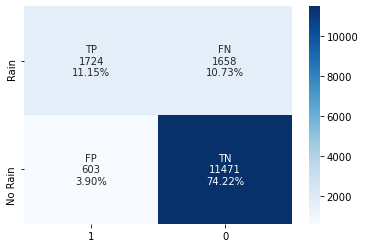

Time spent: 23.43


In [40]:
from sklearn.ensemble import AdaBoostClassifier
adaB = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1
)

cross_validation(adaB)

1. Training set accuracy: 88.88%
2. Validation accuracy: 86.56%
3. Precision(How many days labeled as rainy are actually rainy?): 0.78
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.53
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.96
6. F1 score: 0.63
7. ROC Area under Curve: 0.75


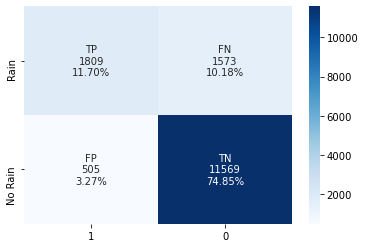

Time spent: 119.49


In [46]:
from sklearn.ensemble import AdaBoostClassifier
adaB1 = AdaBoostClassifier(
    base_estimator = rfc,
    n_estimators=5,
    learning_rate=1
)

cross_validation(adaB1)

1. Training set accuracy: 85.78%
2. Validation accuracy: 82.71%
3. Precision(How many days labeled as rainy are actually rainy?): 0.58
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.78
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.84
6. F1 score: 0.67
7. ROC Area under Curve: 0.81


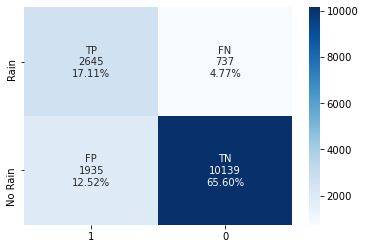

Time spent: 118.18


In [47]:
from sklearn.ensemble import AdaBoostClassifier
adaB2 = AdaBoostClassifier(
    base_estimator = rfc_bal,
    n_estimators=5,
    learning_rate=1
)

cross_validation(adaB2)

## 6.3 Costomized boosting

SGDClassifier boosting accuracy: 0.7811408162737131
3. Precision(How many days labeled as rainy are actually rainy?): nan
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.0
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 1.0
6. F1 score: nan


<ipython-input-14-f8dab3d70abc>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = round(TP/(TP+FP),2)


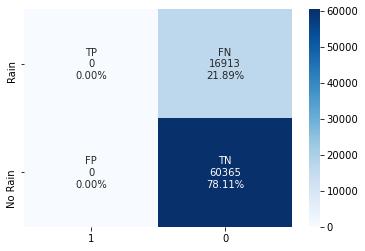

In [69]:
def boosting(clf, X_train, y_train):
    
    clf1 = clf
    clf.fit(X_train, y_train)
    y2 = abs(y_train - clf.predict(X_train))
    clf2 = clf
    clf2.fit(X_train, y2)
    y3 = abs(y2 - clf2.predict(X_train))
    clf3 = clf
    clf3.fit(X_train, y3)
    y_pred = sum(clf.predict(X_train) for tree in (clf1, clf2, clf3))
    print(clf.__class__.__name__, "boosting accuracy:",accuracy_score(y_train, y_pred))
    return y_pred

y_pred_bst = boosting(sgd_clf, X_train, y_train)

visual_cm(y_train, y_pred_bst)

# 7 Ensemble

## 7.1 ensemble simple algorithms

In [66]:
from sklearn.ensemble import VotingClassifier

voting_clf0 = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', rfc), ('sgd', sgd_clf),  
                ("mlpc", model_mlpc)],
    voting='hard')

1. Training set accuracy: 85.61%
2. Validation accuracy: 85.51%
3. Precision(How many days labeled as rainy are actually rainy?): 0.78
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.47
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.96
6. F1 score: 0.59
7. ROC Area under Curve: 0.72


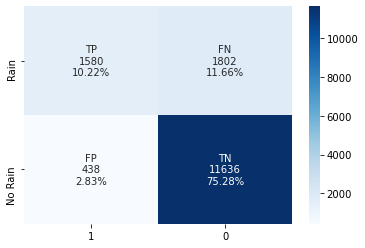

Time spent: 176.01


In [45]:
# add knn and svc later

cross_validation(voting_clf0)

In [67]:
from sklearn.ensemble import VotingClassifier

voting_clf1 = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', rfc), ('sgd', sgd_clf), 
#                 ('AdamBoosting', adaB), ('GradientBoosting', gbc), 
                ("mlpc", model_mlpc), ('RUS',clf_rus),('EasyEnsemble',eec),('BlanceRF',rfc_bal)],
    voting='hard') #('BalanceBagging',clf_bb)

# 7.2 add imbalanced learning models

1. Training set accuracy: 85.82%
2. Validation accuracy: 85.41%
3. Precision(How many days labeled as rainy are actually rainy?): 0.7
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.59
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.93
6. F1 score: 0.64
7. ROC Area under Curve: 0.76


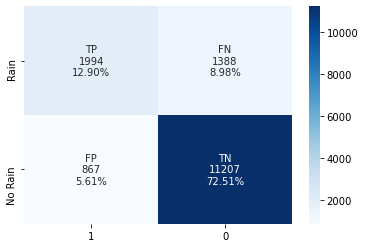

Time spent: 307.21


In [57]:
cross_validation(voting_clf1)
# add knn and svc later

## 7.3 add imbalanced learning and boosting models

In [68]:
from sklearn.ensemble import VotingClassifier

voting_clf2 = VotingClassifier(
    estimators=[('lr', clf_lr), ('rf', rfc), ('sgd', sgd_clf), 
                ('AdamBoosting', adaB), ('GradientBoosting', gbc), 
                ("mlpc", model_mlpc), ('RUS',clf_rus),('EasyEnsemble',eec),('BlanceRF',rfc_bal)],
    voting='hard') #('BalanceBagging',clf_bb)

1. Training set accuracy: 86.18%
2. Validation accuracy: 85.85%
3. Precision(How many days labeled as rainy are actually rainy?): 0.72
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.57
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.94
6. F1 score: 0.64
7. ROC Area under Curve: 0.76


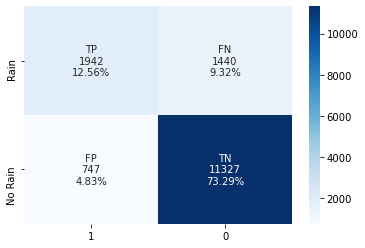

Time spent: 424.71


In [50]:
cross_validation(voting_clf2)

In [ ]:
cross_validation(voting_clf, X_train = X_train1[imp_15_Freq], X_valid = X_valid[imp_15_Freq] )

# 8 Test

remeber to use most important 15 features if models were trained with them.

In [ ]:
estimators=[('lr', clf_lr), ('rf', rfc), ('sgd', sgd_clf), 
                ('AdamBoosting', adaB), ('GradientBoosting', gbc), 
                ("mlpc", model_mlpc), ('RUS',clf_rus),('EasyEnsemble',eec),('BalanceBagging',clf_bb),('BlanceRF',rfc_bal)],
    

In [63]:
def test_model(clf, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    time0 = time.time()
    clf = clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred_train)
    print("1. Training set accuracy:","{0:.2%}".format(acc))
    
    y_pred = clf.predict(X_test)
    score_cv = accuracy_score(y_test, y_pred)
    print("2. Test set accuracy:", "{0:.2%}".format(score_cv))
    
    if acc - score_cv < -0.01 :
        print("       Underfitting by:", "{0:.2%}".format(score_cv - acc))
        
    visual_cm(y_test, y_pred)
    print("7. ROC Area under Curve:", round(metrics.roc_auc_score(y_test, y_pred),2))
    plt.show()
    print("Time Spent:", round((time.time()- time0),2))
    return clf, y_pred_train, y_pred

## 8.1 Adaboost of Random forest with down sampling

In [ ]:
test_model(adaB2)

In [ ]:
# test on 15 most important features
test_model(adaB2, X_train = X_train[imp_15_Freq], X_test = X_test[imp_15_Freq])

## 8.2 Nerual Network

In [ ]:
test_model(model_mlpc)

In [ ]:
test_model(model_mlpc, X_train = X_train[imp_15_Freq], X_test = X_test[imp_15_Freq])

## 8.3 Ensemble of all

1. Training set accuracy: 85.68%
2. Test set accuracy: 83.72%
3. Precision(How many days labeled as rainy are actually rainy?): 0.65
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.64
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.9
6. F1 score: 0.64
7. ROC Area under Curve: 0.77


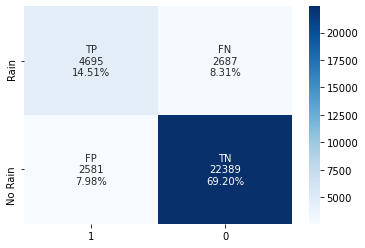

Time Spent: 429.15


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=50, penalty='l1',
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(max_depth=8,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('sgd', SGDClassifier(random_state=42)),
                              ('mlpc',
                               MLPClassifier(batch_size=10, early_stopping=True,
                                             hidden_layer_sizes=(25, 25, 25),
                                             max_iter=10000, solver='lbfgs',
                                             tol=0.001)),
                              ('RUS', RUSBoostClassifier(random_state=0)),
                              ('EasyEnsemble',
                               EasyEnsembleCla

In [74]:
test_model(voting_clf1)

In [ ]:
test_model(voting_clf, X_train = X_train[imp_15_Freq], X_test = X_test[imp_15_Freq])

1. Training set accuracy: 84.93%
2. Test set accuracy: 84.17%
3. Precision(How many days labeled as rainy are actually rainy?): 0.74
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.47
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.95
6. F1 score: 0.57
7. ROC Area under Curve: 0.71


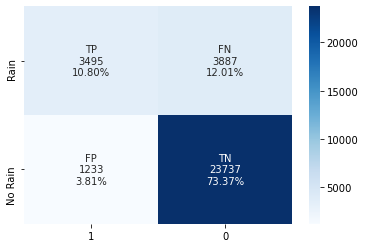

Time Spent: 38.8


(LogisticRegression(C=0.9, penalty='l1', solver='liblinear'),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [94]:
test_model(clf_lr)

# 9 Final - Test on Safe data

In [58]:
df_safe = pd.read_csv("safe_data.csv")
df_safe["Date"] = pd.to_datetime(df_safe['Date'])
df_safe.insert(1, "Year", df_safe["Date"].dt.year, True)

In [60]:
train_df_full = df.copy(deep=True)
train_df_full, medians_full, pt_fit_full, mms_fit_full = preprocess(df)

safe = df_safe.copy(deep=True)
# use the medians in training set to fill missing values in test days
safe_df= preprocess(safe, medians_full, pt_fit_full, mms_fit_full)

train_df_full.shape,train_df_full.shape, safe.shape, safe_df.shape

((109630, 111), (109630, 111), (32552, 25), (32549, 111))

In [61]:
X_train_full = train_df_full.drop(columns = ["RainTomorrow",'Year'], axis = 1)
y_train_full = train_df_full["RainTomorrow"]

X_safe = safe_df.drop(columns = ["RainTomorrow",'Year'], axis = 1)
y_safe = safe_df["RainTomorrow"]

X_train_full.shape,y_train_full.shape, X_safe.shape, y_safe.shape

((109630, 109), (109630,), (32549, 109), (32549,))

## 9.1 Ensemble of all

1. Training set accuracy: 85.58%
2. Test set accuracy: 83.58%
3. Precision(How many days labeled as rainy are actually rainy?): 0.64
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.66
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.89
6. F1 score: 0.65
7. ROC Area under Curve: 0.77


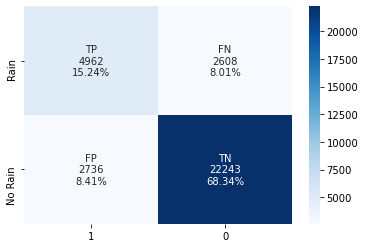

Time Spent: 489.03


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=50, penalty='l1',
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(max_depth=8,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('sgd', SGDClassifier(random_state=42)),
                              ('mlpc',
                               MLPClassifier(batch_size=10, early_stopping=True,
                                             hidden_layer_sizes=(25, 25, 25),
                                             max_iter=10000, solver='lbfgs',
                                             tol=0.001)),
                              ('RUS', RUSBoostClassifier(random_state=0)),
                              ('EasyEnsemble',
                               EasyEnsembleCla

In [70]:
test_model(voting_clf1, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe )

1. Training set accuracy: 84.88%
2. Test set accuracy: 83.55%
3. Precision(How many days labeled as rainy are actually rainy?): 0.69
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.54
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.92
6. F1 score: 0.61
7. ROC Area under Curve: 0.73


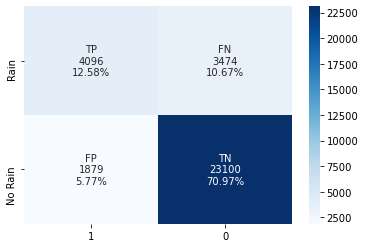

Time Spent: 154.83


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=50, penalty='l1',
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(max_depth=8,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('sgd', SGDClassifier(random_state=42)),
                              ('mlpc',
                               MLPClassifier(batch_size=10, early_stopping=True,
                                             hidden_layer_sizes=(25, 25, 25),
                                             max_iter=10000, solver='lbfgs',
                                             tol=0.001)),
                              ('RUS', RUSBoostClassifier(random_state=0)),
                              ('EasyEnsemble',
                               EasyEnsembleCla

In [75]:
test_model(voting_clf1, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe )

1. Training set accuracy: 85.68%
2. Test set accuracy: 83.72%
3. Precision(How many days labeled as rainy are actually rainy?): 0.65
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.64
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.9
6. F1 score: 0.64
7. ROC Area under Curve: 0.77


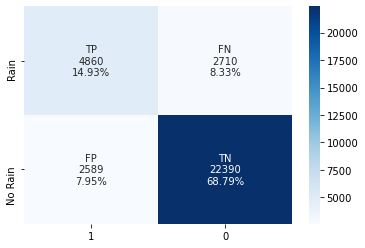

Time Spent: 998.24


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=50, penalty='l1',
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(max_depth=8,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('sgd', SGDClassifier(random_state=42)),
                              ('AdamBoosting',
                               AdaBoostClassifier(learning_rate=1,
                                                  n_estimators=100)),
                              ('GradientBoosting',
                               GradientBoostingClassifier(random_state=0)),
                              ('mlpc',
                               MLPClassifier(batch_size=10, early_stopping=True,
                                             hidden_layer_sizes=(25, 2

In [82]:
test_model(voting_clf2, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe )

1. Training set accuracy: 85.33%
2. Test set accuracy: 83.45%
3. Precision(How many days labeled as rainy are actually rainy?): 0.66
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.58
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.91
6. F1 score: 0.62
7. ROC Area under Curve: 0.75


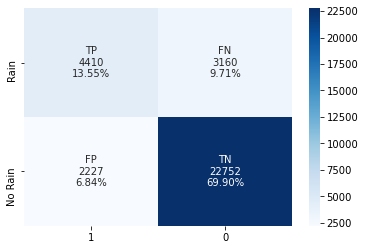

Time Spent: 326.32


(VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=50, penalty='l1',
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(max_depth=8,
                                                      n_estimators=200,
                                                      random_state=42)),
                              ('sgd', SGDClassifier(random_state=42)),
                              ('AdamBoosting',
                               AdaBoostClassifier(learning_rate=1,
                                                  n_estimators=100)),
                              ('GradientBoosting',
                               GradientBoostingClassifier(random_state=0)),
                              ('mlpc',
                               MLPClassifier(batch_size=10, early_stopping=True,
                                             hidden_layer_sizes=(25, 2

In [83]:
test_model(voting_clf2, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe )

## 9.2 Neural Network

1. Training set accuracy: 87.24%
2. Test set accuracy: 85.42%
3. Precision(How many days labeled as rainy are actually rainy?): 0.74
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.58
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.94
6. F1 score: 0.65
7. ROC Area under Curve: 0.76


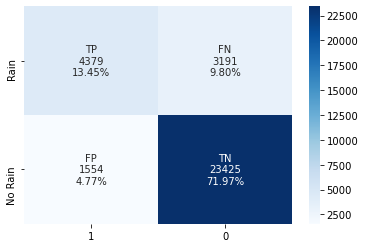

Time Spent: 294.84


(MLPClassifier(batch_size=10, early_stopping=True,
               hidden_layer_sizes=(25, 25, 25), max_iter=10000, solver='lbfgs',
               tol=0.001),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [64]:
test_model(model_mlpc, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 85.03%
2. Test set accuracy: 83.24%
3. Precision(How many days labeled as rainy are actually rainy?): 0.66
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.57
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.91
6. F1 score: 0.61
7. ROC Area under Curve: 0.74


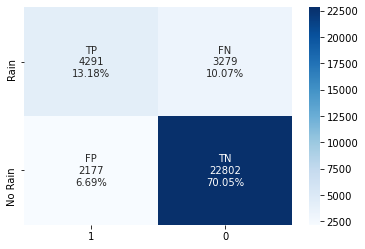

Time Spent: 154.4


(MLPClassifier(batch_size=10, early_stopping=True,
               hidden_layer_sizes=(25, 25, 25), max_iter=10000, solver='lbfgs',
               tol=0.001),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [65]:
test_model(model_mlpc, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe )

## 9.3 adaboost of random forest with class weight

1. Training set accuracy: 84.05%
2. Test set accuracy: 78.80%
3. Precision(How many days labeled as rainy are actually rainy?): 0.53
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.81
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.78
6. F1 score: 0.64
7. ROC Area under Curve: 0.79


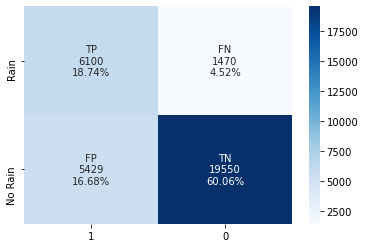

Time Spent: 205.9


(AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                          max_depth=8,
                                                          n_estimators=200,
                                                          random_state=42),
                    learning_rate=1, n_estimators=5),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [71]:
test_model(adaB2, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 82.66%
2. Test set accuracy: 76.16%
3. Precision(How many days labeled as rainy are actually rainy?): 0.49
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.8
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.75
6. F1 score: 0.61
7. ROC Area under Curve: 0.77


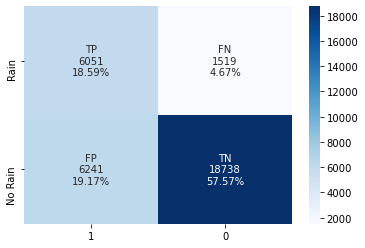

Time Spent: 146.01


(AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                          max_depth=8,
                                                          n_estimators=200,
                                                          random_state=42),
                    learning_rate=1, n_estimators=5),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [77]:
test_model(adaB2, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe ) 

1. Training set accuracy: 87.76%
2. Test set accuracy: 84.71%
3. Precision(How many days labeled as rainy are actually rainy?): 0.73
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.55
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.94
6. F1 score: 0.63
7. ROC Area under Curve: 0.74


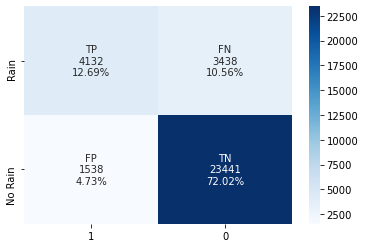

Time Spent: 203.69


(AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=8,
                                                          n_estimators=200,
                                                          random_state=42),
                    learning_rate=1, n_estimators=5),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [72]:
test_model(adaB1, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 87.06%
2. Test set accuracy: 83.81%
3. Precision(How many days labeled as rainy are actually rainy?): 0.7
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.53
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.93
6. F1 score: 0.6
7. ROC Area under Curve: 0.73


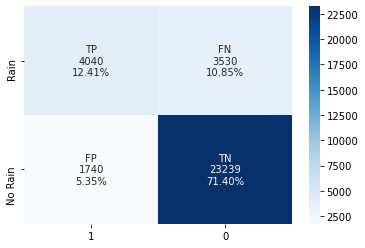

Time Spent: 145.25


(AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=8,
                                                          n_estimators=200,
                                                          random_state=42),
                    learning_rate=1, n_estimators=5),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [76]:
test_model(adaB1, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe ) 

## Random Forest

1. Training set accuracy: 85.44%
2. Test set accuracy: 83.42%
3. Precision(How many days labeled as rainy are actually rainy?): 0.8
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.38
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.97
6. F1 score: 0.52
7. ROC Area under Curve: 0.68


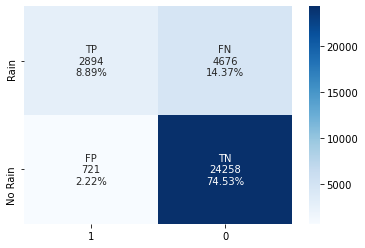

Time Spent: 40.55


(RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [73]:
test_model(rfc, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 85.41%
2. Test set accuracy: 83.48%
3. Precision(How many days labeled as rainy are actually rainy?): 0.78
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.4
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.97
6. F1 score: 0.53
7. ROC Area under Curve: 0.68


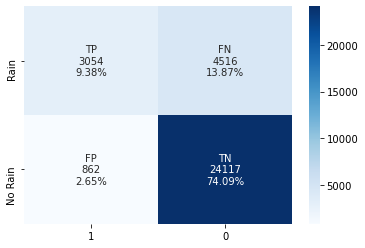

Time Spent: 30.44


(RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [78]:
test_model(rfc, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe ) 

1. Training set accuracy: 84.44%
2. Test set accuracy: 83.49%
3. Precision(How many days labeled as rainy are actually rainy?): 0.68
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.55
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.92
6. F1 score: 0.61
7. ROC Area under Curve: 0.74


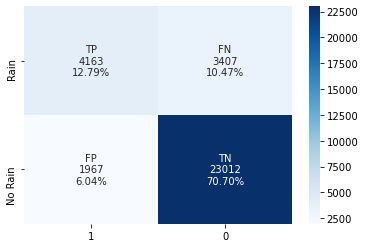

Time Spent: 1.79


(SGDClassifier(random_state=42),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [88]:
test_model(sgd_clf, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 83.62%
2. Test set accuracy: 82.41%
3. Precision(How many days labeled as rainy are actually rainy?): 0.82
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.31
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.98
6. F1 score: 0.45
7. ROC Area under Curve: 0.65


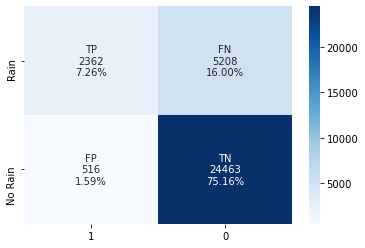

Time Spent: 0.6


(SGDClassifier(random_state=42),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [89]:
test_model(sgd_clf, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe ) 

1. Training set accuracy: 84.73%
2. Test set accuracy: 82.94%
3. Precision(How many days labeled as rainy are actually rainy?): 0.64
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.62
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.89
6. F1 score: 0.63
7. ROC Area under Curve: 0.76


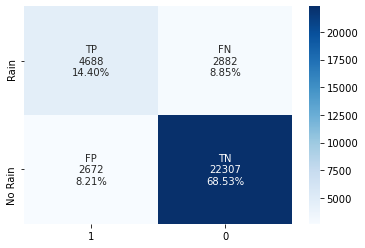

Time Spent: 85.28


(LogisticRegression(C=0.9, penalty='l1', solver='liblinear'),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [95]:
test_model(clf_lr, X_train = X_train_full, y_train = y_train_full, X_test = X_safe , y_test = y_safe)

1. Training set accuracy: 84.45%
2. Test set accuracy: 83.29%
3. Precision(How many days labeled as rainy are actually rainy?): 0.68
4. Sensitivity/Recall(Of all the rainy days, how many of those are correctly predict?): 0.53
5. Specificity(Of all the normal days, how many of those did we correctly predict?): 0.93
6. F1 score: 0.6
7. ROC Area under Curve: 0.73


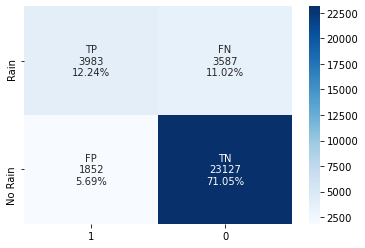

Time Spent: 18.88


(LogisticRegression(C=0.9, penalty='l1', solver='liblinear'),
 array([1., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [96]:
test_model(clf_lr, X_train = X_train_full[imp_15_Freq], y_train = y_train_full, X_test = X_safe[imp_15_Freq], y_test = y_safe ) 

# Reference:
##### circular data transform: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html  
##### Australian weather https://www.finalword.com/map-weather-of-australia/
##### Confusion Matrix Visualization ,Medium https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
##### Ensemble https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch07.html#ensembles_chapter